Some FLAMINGO data is analyzed (in the same was as investigate_field.ipynb).


In [2]:
import  matplotlib.pyplot as plt
import numpy as np
import os
from scipy.fft import rfft2, irfft2 
from scipy.stats import kstest
import matplotlib.cm as cm
import h5py
from python_files.maxent import MaxEnt
import python_files.densities as d
import python_files.figure_settings

In [28]:
path_to_projections = os.getcwd()+"/data/"
types = ["DMO", "HYDRO"]
sims = ["PLANCK", "LOW_SIGMA8", "FIDUCIAL"]
m = 5 #amt of images per cosmology

#create empty dictionary: first level key is the type, second the sim
projections = dict.fromkeys(types)

for typ in types:
    projections[typ] = dict.fromkeys(sims)

for typ in types:
    for sim in sims:
        projections_data = h5py.File(path_to_projections+f'projected_maps_slice_5_L1000N1800_{typ}_{sim}_8192_lc0_alpha_3.6.h5','r')
        projections[typ][sim] = projections_data['proj_maps']



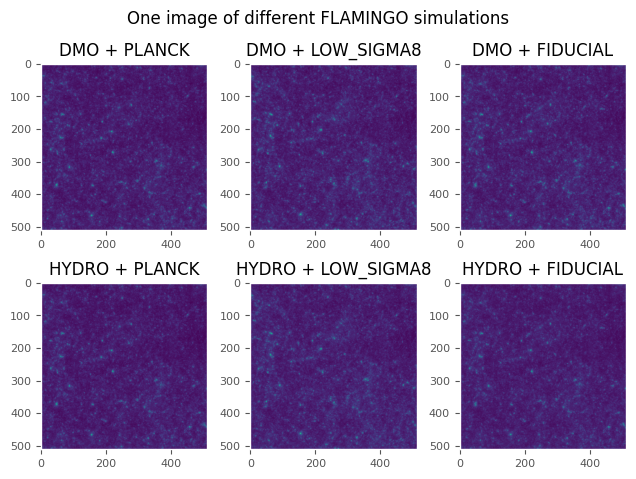

In [23]:

f, ax = plt.subplots(2, 3)
f.suptitle("One image of different FLAMINGO simulations")

for i, typ in enumerate(types):
    for j, sim in enumerate(sims):
        ax[i][j].imshow(projections[typ][sim][0])
        ax[i][j].set_title(typ + " + "+ sim)
        ax[i][j].grid()
plt.tight_layout()
plt.savefig("figs/flamingo_figs.pdf")
plt.show()

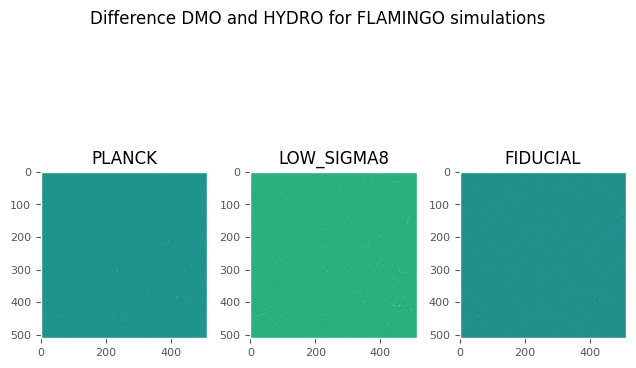

In [25]:
f, ax = plt.subplots(1, 3)
f.suptitle("Difference DMO and HYDRO for FLAMINGO simulations")
for j, sim in enumerate(sims):
    ax[j].imshow(projections[types[0]][sim][1]-projections[types[1]][sim][1])
    ax[j].set_title(sim)
    ax[j].grid()
plt.tight_layout()
plt.show()

In [ ]:
# HYDRO has larger skewness and larger kurtosis
for typ in types:
    for sim in sims:
        skews, kurts = np.zeros((2,m))
        for i in range(m):
            arr = (projections[typ][sim][i]).flatten()
            mu = np.mean(arr)
            s2 = np.var(arr)
            arr_standard = (arr-mu)/np.sqrt(s2)
            skews[i] = np.mean(arr_standard**3)
            kurts[i] = np.mean(arr_standard**4)
        print(f"Avg. skewness: {np.mean(skews):.2f} || Avg kurtosis: {np.mean(kurts):.2f} || ({typ},{sim})")

Avg. skewness: 2.84 || Avg kurtosis: 22.17 || (DMO,PLANCK)
Avg. skewness: 2.72 || Avg kurtosis: 20.83 || (DMO,LOW_SIGMA8)
Avg. skewness: 2.85 || Avg kurtosis: 22.70 || (DMO,FIDUCIAL)
Avg. skewness: 2.92 || Avg kurtosis: 23.81 || (HYDRO,PLANCK)
Avg. skewness: 2.76 || Avg kurtosis: 21.87 || (HYDRO,LOW_SIGMA8)
Avg. skewness: 2.93 || Avg kurtosis: 24.19 || (HYDRO,FIDUCIAL)


Skewness: 2.90 || Kurtosis: 23.31


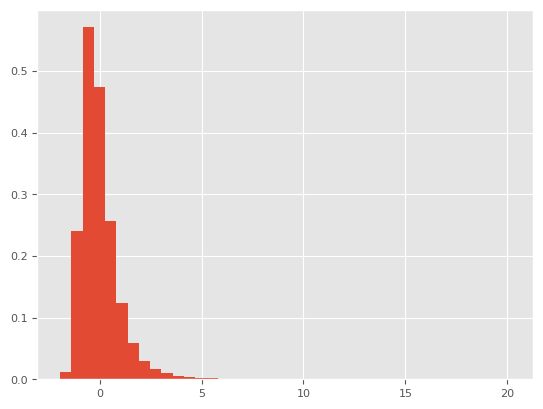

The resulting parameters:
  Lambda_1 = -0.405
  Lambda_2 = -0.783
  Lambda_3 = 0.165
  Lambda_4 = -0.009


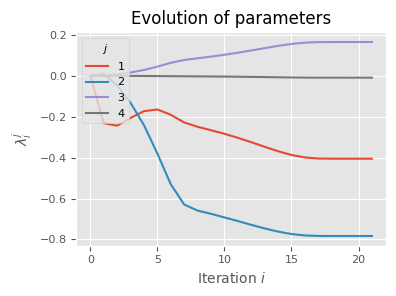

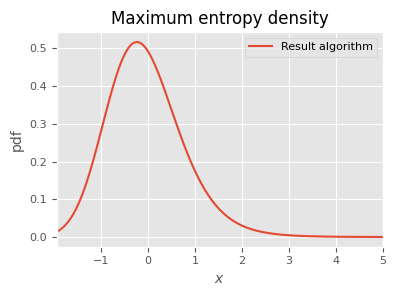

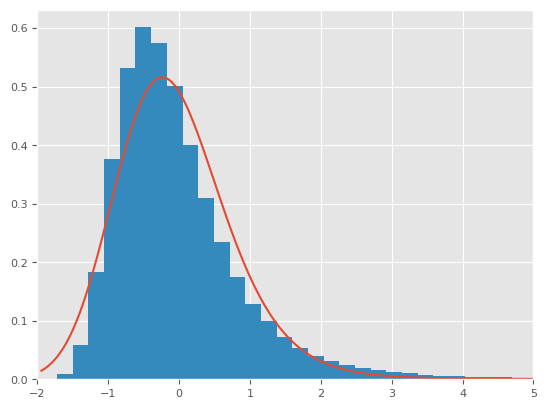

In [ ]:

arr = (projections[types[0]][sims[0]][1]).flatten()
mu = np.mean(arr)
s2 = np.var(arr)
arr_standard = (arr-mu)/np.sqrt(s2)
skew = np.mean(arr_standard**3)
kurt = np.mean(arr_standard**4)
print(f"Skewness: {skew:.2f} || Kurtosis: {kurt:.2f}")

plt.hist(arr_standard, density=True, bins=40)
plt.title("Standardized marginal")
plt.show()

l = np.min(arr_standard)
u = np.max(arr_standard)
n = 150

ob_skewkurt = MaxEnt(support=(l,u),
                    n_quadrature=n,
                    b_constraints=d.b_constraint_skewkurt(skew,kurt),
                    f_vector=d.f_constraint_skewkurt)
ob_skewkurt.visualize_algorithm()
ob_skewkurt.visualize_solution(xlim=(l,5))

N=500
xx = np.linspace(l,5,N)

y = ob_skewkurt.pdf(xx)
plt.plot(xx,y)
plt.hist(arr_standard, density=True, bins=100)
plt.xlim(-2,5)
plt.show()

In [11]:
# Z = rfft2(im)

# f, (ax1, ax2) = plt.subplots(1, 2)#, sharex='col', sharey='row'

# ax1.imshow(im)#, cmap=cm.Reds
# ax2.imshow(np.real(Z), cmap=cm.gray)
# plt.show()
# print(Z)

In [34]:
def batch_rejection_sample(density, xlim, C, N):
    Y = np.random.uniform(*xlim,size=N)
    U = np.random.uniform(size=N)
    mask = (U <= (xlim[1]-xlim[0])*density(Y)/C)
    return Y[mask]

def rejection_sampling(size, density, xlim, n_batch=5000):
    """Univariate rvs, on closed support [a,b]
    - density should be vectorizable"""

    # Determine C s.t. density(x) <= C * (b-a)^-1
    N = 10000
    xx = np.linspace(*xlim,N)
    yy = density(xx)
    C = np.max(yy)*(xlim[1]-xlim[0])
    
    results = np.array([])
    while(results.size<size):
        results = np.append(results, batch_rejection_sample(density,xlim,
                                                            C,N=1000))
    
    return results[:size]



In [ ]:
def standardize_image(image):
    mean = np.mean(image)
    var = np.var(image)
    return (image-mean)/np.sqrt(var)

def generate_copy_image(image_raw, 
                        name,
                        extra_upper_l=0.00, 
                        n=150, 
                        u_show=None):
    mean = np.mean(image_raw)
    var = np.var(image_raw)
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = np.max(image_raw)

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt,
                        k_max=200, 
                        message_norm=False)
    # ob_skewkurt.visualize_algorithm()
    # ob_skewkurt.visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt.pdf, 
                                   xlim=(l,u),
                                   n_batch=1000)*np.sqrt(var) + mean
    
    res_sample = kstest(image_raw.flatten(), sample_ME)
    n_breaks = 50
    bins = np.linspace(np.min(image_raw), np.max(image_raw), n_breaks)

    fig, ax = plt.subplots(3,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {name}")
    ax[0].grid()
    
    ax[1].hist(image_raw.flatten(), density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(np.min(image_raw), np.max(image_raw))
    ax[1].legend()

    ax[2].hist(image_raw.flatten(), density=True, bins=bins, alpha=0.6, label="Real")
    ax[2].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[2].set_title(f"Histogram of pixel values ($p$-val. KS test: {res_sample.pvalue:.1e})")
    ax[2].set_xlabel("Pixel value")
    ax[2].set_ylabel("Density")
    ax[2].set_xlim(np.min(image_raw), np.max(image_raw))
    ax[2].set_yscale("log")
    ax[2].legend()

    plt.tight_layout()
    plt.savefig(f"figs/generated_copy_pres_{name}_log.pdf")
    plt.show()

def generate_copy_image_8(image_raw, 
                        name,
                        extra_upper_l=0.00, 
                        n=150, 
                        u_show=None):
    mean = np.mean(image_raw)
    var = np.var(image_raw)
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = np.max(image_raw)

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)
    m8 = np.mean(image_flat**8)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt,m8),
                        f_vector=d.f_constraint_skewkurt_8,
                        k_max=400, 
                        message_norm=False)
    # ob_skewkurt.visualize_algorithm()
    # ob_skewkurt.visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt.pdf, 
                                   xlim=(l,u),
                                   n_batch=1000)*np.sqrt(var) + mean
    
    res_sample = kstest(image_raw.flatten(), sample_ME)
    n_breaks = 50
    bins = np.linspace(np.min(image_raw), np.max(image_raw), n_breaks)

    fig, ax = plt.subplots(3,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {name}")
    ax[0].grid()
    
    ax[1].hist(image_raw.flatten(), density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(np.min(image_raw), np.max(image_raw))
    ax[1].legend()

    ax[2].hist(image_raw.flatten(), density=True, bins=bins, alpha=0.6, label="Real")
    ax[2].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    ax[2].set_title(f"Histogram of pixel values ($p$-val. KS test: {res_sample.pvalue:.1e})")
    ax[2].set_xlabel("Pixel value")
    ax[2].set_ylabel("Density")
    ax[2].set_xlim(np.min(image_raw), np.max(image_raw))
    ax[2].set_yscale("log")
    ax[2].legend()

    plt.tight_layout()
    plt.savefig(f"figs/generated_copy_pres_{name}_log_8.pdf")
    plt.show()

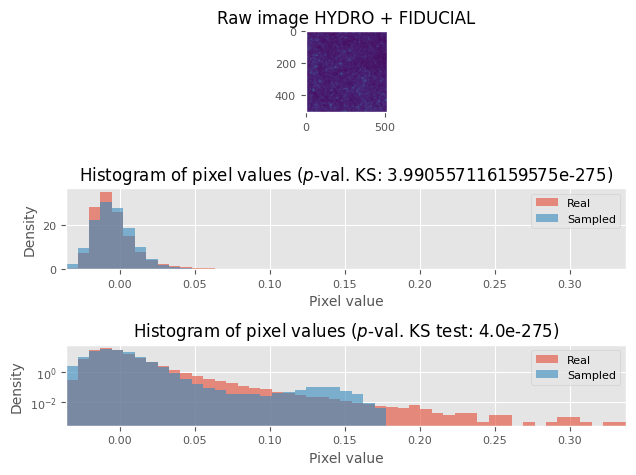

In [41]:
generate_copy_image(projections[types[0]][sims[0]][0],
                    name=typ+" + "+sim,
                    n=250)

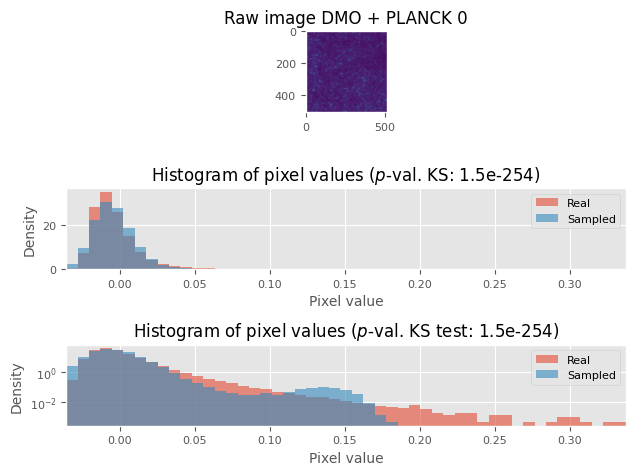

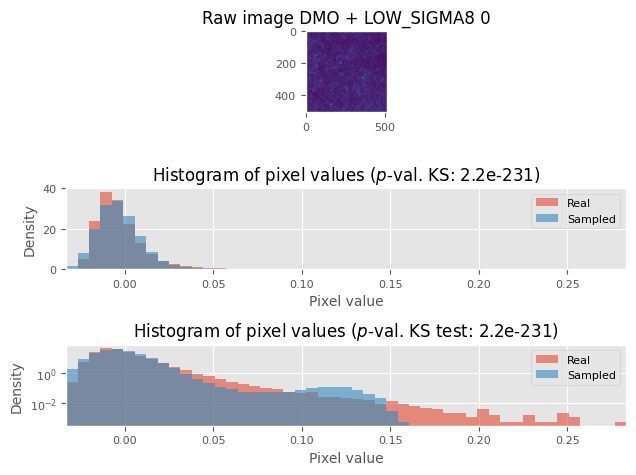

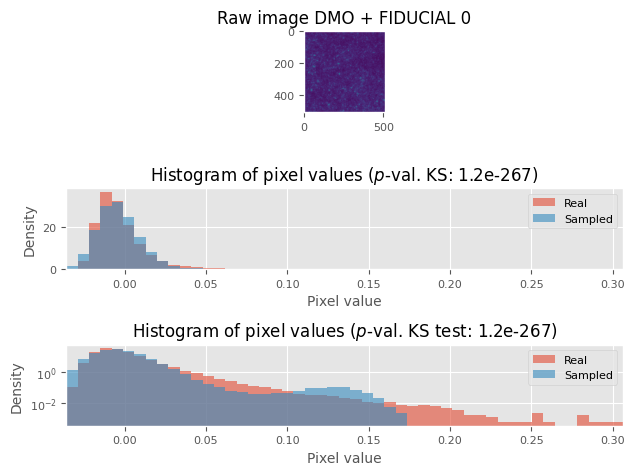

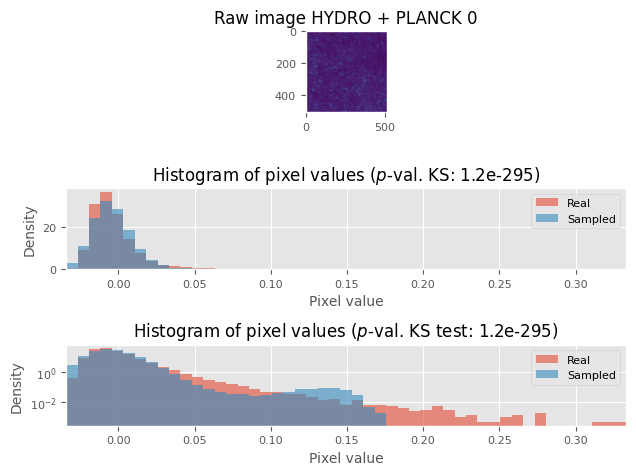

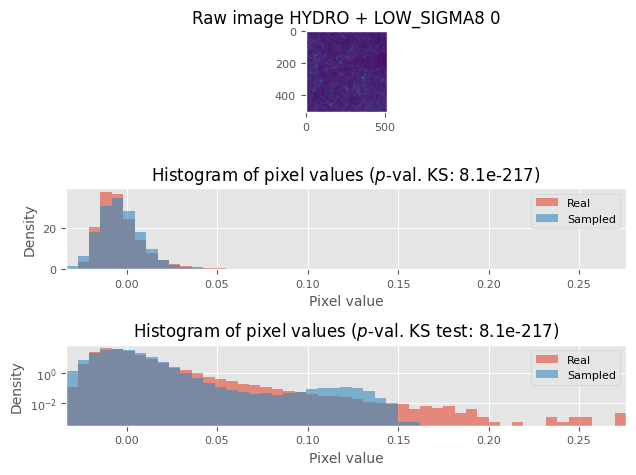

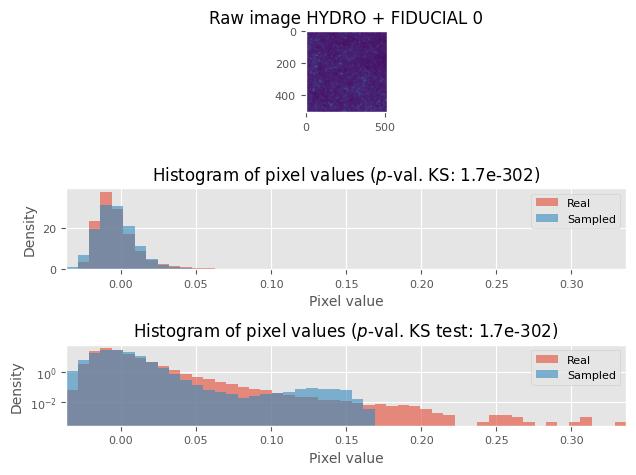

In [46]:
k=0
for i, typ in enumerate(types):
    for j, sim in enumerate(sims):
        generate_copy_image(projections[typ][sim][k],
                        name=typ+" + "+sim+f" {k}",
                        n=250)

In [ ]:
k=0
for i, typ in enumerate(types):
    for j, sim in enumerate(sims):
        generate_copy_image_8(projections[typ][sim][k],
                        name=typ+" + "+sim+f" {k}",
                        n=250)

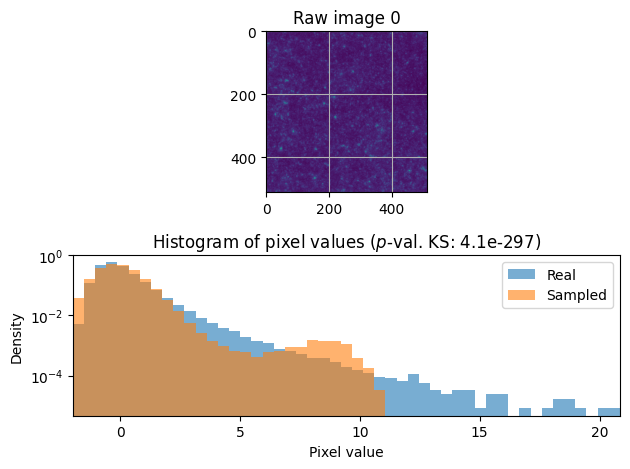

In [ ]:
#logarithmic plot
# for i in range(1):
#     generate_copy_image(projections[i],
#                         ,
#                         extra_upper_l=0, 
#                         n=150)